<a href="https://colab.research.google.com/github/bhavinithak/DeepLearning_Pytorch/blob/main/Titanic_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle

In [2]:
creds='{"username":"","key":""}'
from pathlib import Path

cred_path = Path('~/.kaggle/kaggle.json').expanduser()
if not cred_path.exists():
    cred_path.parent.mkdir(exist_ok=True)
    cred_path.write_text(creds)
    cred_path.chmod(0o600)

path=Path('titanic')

if not path.exists():
    import zipfile,kaggle
    kaggle.api.competition_download_cli(str(path))
    zipfile.ZipFile(f'{path}.zip').extractall(path)

!ls {path}

100%|██████████| 34.1k/34.1k [00:00<00:00, 9.90MB/s]


gender_submission.csv  test.csv  train.csv


In [29]:
from fastai.tabular.all import *

pd.options.display.float_format='{:.2f}'.format
set_seed(42)

#Data Prep

In [43]:
df=pd.read_csv(path/'train.csv')

In [44]:
def add_features(df):
  df['LogFare']=np.log1p(df['Fare'])
  df['Deck'] = df.Cabin.str[0].map(dict(A='ABC',B='ABC',C='ABC',D='DE',E='DE',F='FG',G='FG'))
  df['Family']=df.SibSp+df.Parch
  df['Alone']=df.Family==1
  df['TicketFreq']=df.groupby('Ticket')['Ticket'].transform('count')
  df['Title']=df.Name.str.split(', ',expand=True)[1].str.split('.', expand=True)[0]
  df['Title']=df.Title.map(dict(Mr='Mr',Miss='Miss',Mrs='Mrs',Master='Master'))


In [45]:
add_features(df)

In [46]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,LogFare,Deck,Family,Alone,TicketFreq,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.00,1,0,A/5 21171,7.25,NaN,S,2.11,NaN,1,True,1,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.00,1,0,PC 17599,71.28,C85,C,4.28,ABC,1,True,1,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.00,0,0,STON/O2. 3101282,7.92,NaN,S,2.19,NaN,0,False,1,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.00,1,0,113803,53.10,C123,S,3.99,ABC,1,True,2,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.00,0,0,373450,8.05,NaN,S,2.20,NaN,0,False,1,Mr


In [47]:
splits=RandomSplitter(seed=42)(df)

In [48]:
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'LogFare', 'Deck',
       'Family', 'Alone', 'TicketFreq', 'Title'],
      dtype='object')

In [50]:
dls=TabularPandas(
    df, splits=splits,
    procs=[Categorify, FillMissing, Normalize],
    cat_names=['Sex','Pclass','Embarked','Deck','Title'],
    cont_names=['Age', 'SibSp', 'Parch', 'LogFare', 'Alone', 'TicketFreq', 'Family'],
    y_names="Survived", y_block = CategoryBlock()
).dataloaders(path=".")

#Train model

In [51]:
learn = tabular_learner(dls, metrics=accuracy, layers=[10,10])

SuggestedLRs(slide=0.12022644281387329, valley=0.005248074419796467)

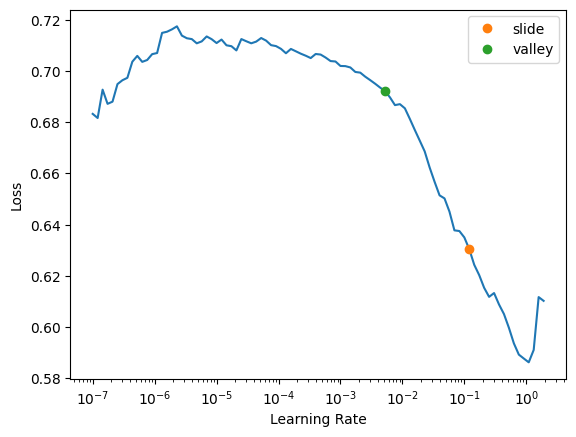

In [52]:
learn.lr_find(suggest_funcs=(slide, valley))

In [53]:
learn.fit(16, lr=0.03)

epoch,train_loss,valid_loss,accuracy,time
0,0.566262,0.563902,0.595506,00:00
1,0.503330,0.477804,0.758427,00:00
2,0.465172,0.423246,0.820225,00:00
3,0.436244,0.443095,0.825843,00:00
4,0.427813,0.468378,0.831461,00:00
5,0.415492,0.453219,0.820225,00:00
6,0.408817,0.441804,0.814607,00:00
7,0.400937,0.417426,0.808989,00:00
8,0.394328,0.425478,0.837079,00:00
9,0.388572,0.448531,0.825843,00:00


#Test data

In [54]:
test_df=pd.read_csv(path/'test.csv')

In [55]:
test_df['Fare']=test_df['Fare'].fillna(0)

In [56]:
add_features(test_df)

In [57]:
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,LogFare,Deck,Family,Alone,TicketFreq,Title
0,892,3,"Kelly, Mr. James",male,34.50,0,0,330911,7.83,NaN,Q,2.18,NaN,0,False,1,Mr
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.00,1,0,363272,7.00,NaN,S,2.08,NaN,1,True,1,Mrs
2,894,2,"Myles, Mr. Thomas Francis",male,62.00,0,0,240276,9.69,NaN,Q,2.37,NaN,0,False,1,Mr
3,895,3,"Wirz, Mr. Albert",male,27.00,0,0,315154,8.66,NaN,S,2.27,NaN,0,False,1,Mr
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.00,1,1,3101298,12.29,NaN,S,2.59,NaN,2,False,1,Mrs


In [59]:
tst_dl=learn.dls.test_dl(test_df)

In [60]:
preds,_=learn.get_preds(dl=tst_dl)

In [63]:
test_df['Survived']=(preds[:,1]>0.5).int()

In [69]:
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,LogFare,Deck,Family,Alone,TicketFreq,Title,Survived
0,892,3,"Kelly, Mr. James",male,34.50,0,0,330911,7.83,NaN,Q,2.18,NaN,0,False,1,Mr,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.00,1,0,363272,7.00,NaN,S,2.08,NaN,1,True,1,Mrs,0
2,894,2,"Myles, Mr. Thomas Francis",male,62.00,0,0,240276,9.69,NaN,Q,2.37,NaN,0,False,1,Mr,0
3,895,3,"Wirz, Mr. Albert",male,27.00,0,0,315154,8.66,NaN,S,2.27,NaN,0,False,1,Mr,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.00,1,1,3101298,12.29,NaN,S,2.59,NaN,2,False,1,Mrs,1


#Ensembling

In [71]:
def ensemble():
    learn = tabular_learner(dls, metrics=accuracy, layers=[10,10])
    with learn.no_bar(),learn.no_logging(): learn.fit(16, lr=0.03)
    return learn.get_preds(dl=tst_dl)[0]

In [72]:
learns = [ensemble() for _ in range(5)]

In [73]:
ens_preds = torch.stack(learns).mean(0)

In [75]:
test_df['Survived_ensemble'] = (ens_preds[:,1]>0.5).int()